# Drawing the likelihood contours

Amongst the material to be presented in the final results is the contours in branching fraction space.  Here I will draw the contours based on the assumption that the pdf for the branching fractions can be approximated by a three (or four if we include the hadronic fraction) dimensional Gaussian.  

In [1]:
## imports and configuration
%cd '/home/naodell/work/wbr/analysis'
#%load_ext autoreload

from functools import partial
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from scipy.stats import multivariate_normal, norm
from tqdm import tqdm_notebook

import scripts.plot_tools as pt
import scripts.fit_helpers as fh
from nllfit.nllfitter import ScanParameters

np.set_printoptions(precision=4)
rc_params = {
             'figure.figsize': (10, 10),
             'axes.labelsize': 20,
             'axes.facecolor': 'white',
             'axes.titlesize':'x-large',
             'legend.fontsize': 20,
             'xtick.labelsize':20,
             'ytick.labelsize':20,
             'font.size':18,
             'font.sans-serif':['Arial', 'sans-serif'],
             'mathtext.sf':'Arial',
             'lines.markersize':8.,
             'lines.linewidth':2.5,
            }
matplotlib.rcParams.update(rc_params)

%connect_info

/home/naodell/work/wbr/analysis
{
  "shell_port": 58147,
  "iopub_port": 48451,
  "stdin_port": 60089,
  "control_port": 41505,
  "hb_port": 59799,
  "ip": "127.0.0.1",
  "key": "9ea89166-3a1eebb0e9bbbd253a8a203e",
  "transport": "tcp",
  "signature_scheme": "hmac-sha256",
  "kernel_name": ""
}

Paste the above JSON into a file, and connect with:
    $> jupyter <app> --existing <file>
or, if you are local, you can connect with just:
    $> jupyter <app> --existing kernel-b614ecfc-4b5c-462a-abdc-6649dc963d9c.json
or even just:
    $> jupyter <app> --existing
if this is the most recent Jupyter kernel you have started.


## Test the machinery first

The contours will be drawn as two dimendional projections of the three dimensional Gaussian that is determined from the likelihood.  To understand how this is done, I will first carry out the problem in the easier to visualize two to one dimensional case.  When doing the projection, we can approach it in two ways: 

   1. marginalize over the dimension that is not being displayed, i.e., $P(x) = \int_{-\infty}^{\infty} P(x, y) dy$,
   2. use the optimal value of the dimension not being displayed.  This can be achieved by finding the line (or (hyper)plane) defined by the eigenvectors of the covariance matrix.
   
I will compare these two approaches here.  

*After messing around with this, I've come to the conclusion that you just draw the projection using the appropriate sub-matrix of the full covariance matrix.  So for the two to one dimensional case, this means the projections are just defined by the variances for the x and y component.  I suppose this is mostly obvious, but it took this exercise for me to understand it.  I think this result ends up being equivalent to the marginal distribution.*

/home/naodell/opt/anaconda3.7/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: constrained_layout not applied.  At least one axes collapsed to zero width or height.
  fig.canvas.print_figure(bytes_io, **kw)


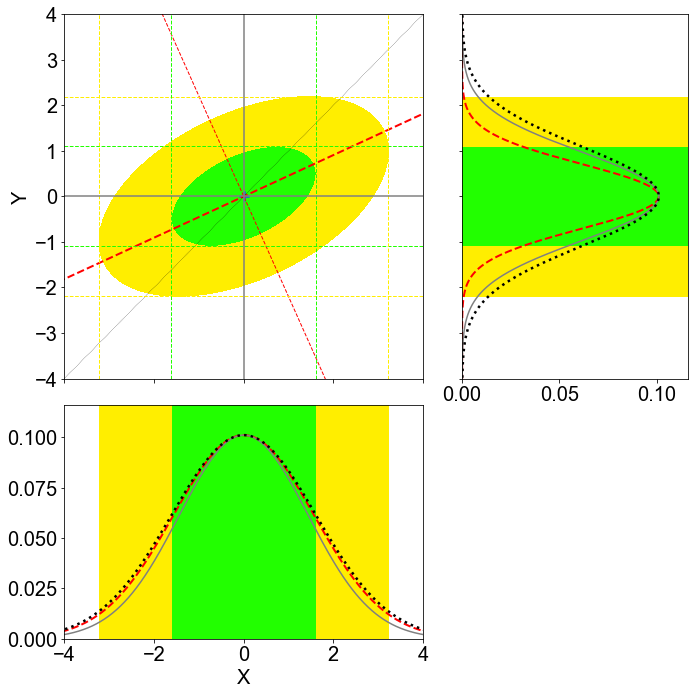

In [2]:
# 2D case
fig = plt.figure(facecolor='white', figsize=(10, 10), constrained_layout=True)
gs = fig.add_gridspec(10, 10)

# define the distribution
mean = [0, 0]
cov = np.array([[2.6, 0.8], 
                [0.8, 1.2]]) 
sig_x = np.sqrt(cov[0, 0])
sig_y = np.sqrt(cov[1, 1])
fnorm = multivariate_normal(mean=mean, cov=cov)

# calculate eigenvalues for drawing projections
eigenvals, eigenvecs = np.linalg.eig(cov)

# generate sample points
x = np.linspace(-5, 5, int(1e3))
X, Y = np.meshgrid(x, x)
pos = np.empty(X.shape + (2,))
pos[:,:,0] = X
pos[:,:,1] = Y

# make the plots
ax = fig.add_subplot(gs[:6, :6])
plt.setp(ax.get_xticklabels(), visible=False)
clvls = [0, 0.5, 2]
ax.plot([0], [0], marker='+', markersize=10, markeredgewidth=3)
slope1, slope2 = eigenvecs[1][0]/eigenvecs[1][1], eigenvecs[0][0]/eigenvecs[0][1]
ax.plot(x, slope1*x, 'r--', linewidth=2)
ax.plot(x, slope2*x, 'r--', linewidth=1)
ax.plot(x, x, 'k:', linewidth=0.5)
cf = ax.contourf(X, Y, -np.log(fnorm.pdf(pos)/fnorm.pdf([0, 0])), levels=clvls, linestyles='solid', colors=['#22FF00', '#FFEE00'])

# y intervals
ax.plot([-4, 4], [2*sig_y, 2*sig_y], color='#FFEE00', linestyle='--', linewidth=1.)
ax.plot([-4, 4], [-2*sig_y, -2*sig_y], color='#FFEE00', linestyle='--', linewidth=1.)
ax.plot([-4, 4], [sig_y, sig_y], color='#22FF00', linestyle='--', linewidth=1.)
ax.plot([-4, 4], [-sig_y, -sig_y], color='#22FF00', linestyle='--', linewidth=1.)

# y intervals
ax.plot([2*sig_x, 2*sig_x], [-4, 4], color='#FFEE00', linestyle='--', linewidth=1.)
ax.plot([-2*sig_x, -2*sig_x], [-4, 4], color='#FFEE00', linestyle='--', linewidth=1.)
ax.plot([sig_x, sig_x], [-4, 4], color='#22FF00', linestyle='--', linewidth=1.)
ax.plot([-sig_x, -sig_x], [-4, 4], color='#22FF00', linestyle='--', linewidth=1.)

# origin
ax.plot([0, 0], [-4, 4], color='gray', linewidth=1.5)
ax.plot([-4, 4], [0, 0], color='gray', linewidth=1.5)

ax.set_ylabel('Y')
ax.set_xlim(-4, 4)
ax.set_ylim(-4, 4)

# y projection
ax_y = fig.add_subplot(gs[:6, 6:], sharey=ax)
plt.setp(ax_y.get_yticklabels(), visible=False)
xy = np.vstack([x/slope1, x]) if slope1 != 0 else np.vstack([np.zeros_like(x), x])
fproj_y = fnorm.pdf(xy.T)
ax_y.plot(fproj_y, x , 'r--', linewidth=2)

xy = np.vstack([np.zeros_like(x), x])
fproj_y_alt = fnorm.pdf(xy.T)
ax_y.plot(fproj_y_alt, x, color='gray', linewidth=1.5)

fnom_y = norm.pdf(x, loc=mean[0], scale=sig_y)
norm_factor = fproj_y_alt.max()/fnom_y.max()
ax_y.plot(norm_factor*fnom_y, x,'k:')

ax_y.fill_between([0, sig_y], [-sig_y, -sig_y], [sig_y, sig_y], color='#22FF00')
ax_y.fill_between([0, sig_y], [-2*sig_y, -2*sig_y], [-sig_y, -sig_y], color='#FFEE00')
ax_y.fill_between([0, sig_y], [sig_y, sig_y], [2*sig_y, 2*sig_y], color='#FFEE00')

ax_y.set_xlim(0, 1.15*fproj_y.max())

# x projection
ax_x = fig.add_subplot(gs[6:, :6], sharex=ax) 
xy = np.vstack([x, slope1*x]).T
fproj_x = fnorm.pdf(xy)
ax_x.plot(x, fproj_x, 'r--', linewidth=2)

xy_alt = np.vstack([x, np.zeros_like(x)]).T
fproj_x_alt = fnorm.pdf(xy_alt)
ax_x.plot(x, fproj_x_alt, color='gray', linewidth=1.5)

fnom_x = norm.pdf(x, loc=mean[0], scale=sig_x)
norm_factor = fproj_x_alt.max()/fnom_x.max()
ax_x.plot(x, norm_factor*fnom_x, 'k:')

ax_x.fill_betweenx([0, sig_x], [-sig_x, -sig_x], [sig_x, sig_x], color='#22FF00')
ax_x.fill_betweenx([0, sig_x], [-2*sig_x, -2*sig_x], [-sig_x, -sig_x], color='#FFEE00')
ax_x.fill_betweenx([0, sig_x], [sig_x, sig_x], [2*sig_x, 2*sig_x], color='#FFEE00')

ax_x.set_ylim(0, 1.15*fproj_x.max())
ax_x.set_xlabel('X')

gs.tight_layout(fig, h_pad=0.)
plt.show()

## Draw contours from full fit

In [3]:
# configure, get the input data, and do any additional processing that is needed

# get data for Asimov dataset fit
parameters_asimov = pd.read_csv('data/model_parameters_asimov.csv', index_col='name')
corr_asimov = pd.read_csv('local_data/corr_table_full_asimov.csv', index_col='label')

# define multivariate normal distributions
val_fit_asimov = parameters_asimov.loc[['beta_e', 'beta_mu', 'beta_tau'], 'val_fit'].values
err_fit_asimov = parameters_asimov.loc[['beta_e', 'beta_mu', 'beta_tau'], 'err_fit'].values
cov_asimov = corr_asimov.iloc[:3, :3].values*np.outer(err_fit_asimov, err_fit_asimov)

# get data for real data fit
parameters_unblinded = pd.read_csv('data/model_parameters_unblinded.csv', index_col='name')
corr_unblinded = pd.read_csv('local_data/corr_table_full_unblinded.csv', index_col='label')

# define multivariate normal distributions
val_fit_unblinded = parameters_unblinded.loc[['beta_e', 'beta_mu', 'beta_tau'], 'val_fit'].values
err_fit_unblinded = parameters_unblinded.loc[['beta_e', 'beta_mu', 'beta_tau'], 'err_fit'].values
cov_unblinded = corr_unblinded.iloc[:3, :3].values*np.outer(err_fit_unblinded, err_fit_unblinded)
f_unblinded = multivariate_normal(mean=val_fit_unblinded, cov=cov_unblinded)

# LEP values
br_lep = np.array([0.1071, 0.1063, 0.1138])
stderr_lep = np.array([0.0016, 0.0015, 0.0021])
corr_lep = np.array([
                     [1., 0.136, -0.201],
                     [0.136, 1., -0.230],
                     [-0.201, -0.122, 1.]
                    ])
cov_lep = corr_lep[:3, :3]*np.outer(stderr_lep, stderr_lep)
f_lep = multivariate_normal(mean=br_lep, cov=cov_lep)

# Ziheng's values
br_alt = np.array([0.1115, 0.1113, 0.1063])
cov_alt = 1e-4*np.array([
                         [ 0.07373008,  0.03392898, -0.01059741],
                         [ 0.03392898,  0.04704586, -0.03741042],
                         [-0.01059741, -0.03741042,  0.42297806]
                        ])
stderr_alt = np.sqrt(cov_alt.diagonal())
corr_alt = cov_alt/np.outer(stderr_alt, stderr_alt)

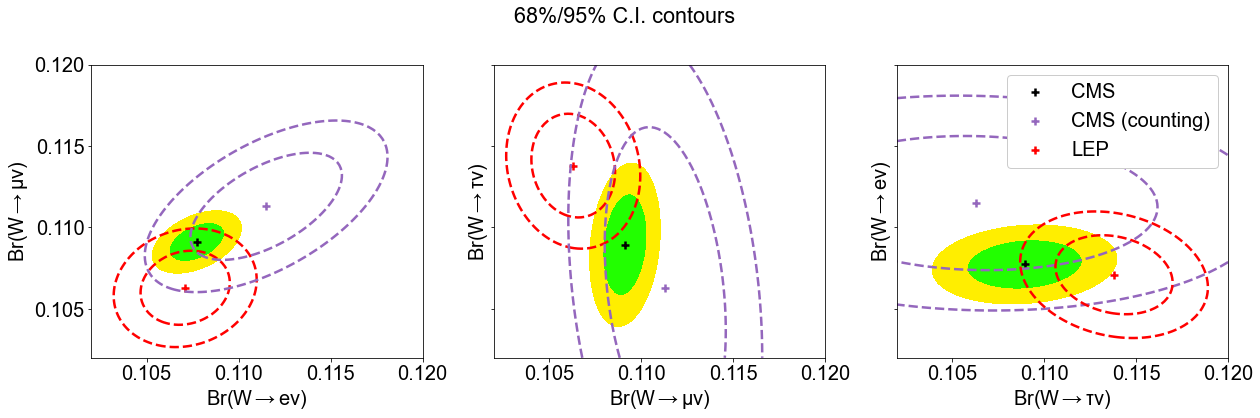

In [16]:
# plot the cost
fig, axes = plt.subplots(1, 3, figsize=(18, 6), facecolor='white', sharex=True, sharey=True)

# plot options
scan_range = (0.102, 0.12)
#clvls = [0., 0.5, 2]
clvls = [0., 2.3, 5.9]
#clvls = [0., 3.527, 8.025]

label_emu = dict(x = r'$Br(W\rightarrow e\nu)$', y = r'$Br(W\rightarrow \mu\nu)$')
label_mutau = dict(x = r'$Br(W\rightarrow \mu\nu)$', y = r'$Br(W\rightarrow \tau\nu)$')
label_etau = dict(x = r'$Br(W\rightarrow \tau\nu)$', y = r'$Br(W\rightarrow e\nu)$')
label_ltau = dict(x = r'$Br(W\rightarrow e\nu/\mu\nu)$', y = r'$Br(W\rightarrow \tau\nu)$')

# define sample points
scan_vals = np.linspace(scan_range[0], scan_range[1], 100)
X, Y = np.meshgrid(scan_vals, scan_vals)
pos = np.empty(X.shape + (2,))
pos[:,:,0] = X
pos[:,:,1] = Y
    
# electron vs. muon
cov_emu = cov_unblinded[:2, :2]
f_emu = multivariate_normal(mean=val_fit_unblinded[:2], cov=cov_unblinded[:2, :2])
nll_emu = -2*np.log(f_emu.pdf(pos)/f_emu.pdf(val_fit_unblinded[:2]))

cov_emu_alt = cov_alt[:2, :2]
f_emu_alt = multivariate_normal(mean=br_alt[:2], cov=cov_alt[:2, :2])
nll_emu_alt = -2*np.log(f_emu_alt.pdf(pos)/f_emu_alt.pdf(br_alt[:2]))

cov_emu_lep = cov_lep[:2, :2]
f_emu_lep = multivariate_normal(mean=br_lep[:2], cov=cov_lep[:2, :2])
nll_emu_lep = -2*np.log(f_emu_lep.pdf(pos)/f_emu_lep.pdf(br_lep[:2]))

ax = axes[0]
ax.contourf(X, Y, nll_emu, levels=clvls, linestyles='solid', colors=['#22FF00', '#FFEE00'])
ax.scatter([val_fit_unblinded[0]], [val_fit_unblinded[1]], marker='+', c='k', label='CMS')
ax.contour(X, Y, nll_emu_lep, levels=clvls, linestyles='--', colors='r')
ax.scatter([br_lep[0]], [br_lep[1]], marker='+', c='r', label='LEP')
ax.contour(X, Y, nll_emu_alt, levels=clvls, linestyles='--', colors='C4')
ax.scatter([br_alt[0]], [br_alt[1]], marker='+', c='C4', label='CMS (alt)')

# draw 1D intervals
#x_down = [val_fit_unblinded[0] - err_fit_unblinded[0], val_fit_unblinded[0] - err_fit_unblinded[0]]
#x_up = [val_fit_unblinded[0] + err_fit_unblinded[0], val_fit_unblinded[0] + err_fit_unblinded[0]]
#ax.plot(x_down, scan_range, color='#22FF00', linestyle='--', linewidth=1.)
#ax.plot(x_up, scan_range, color='#22FF00', linestyle='--', linewidth=1.)
#
#y_down = [val_fit_unblinded[1] - err_fit_unblinded[1], val_fit_unblinded[1] - err_fit_unblinded[1]]
#y_up = [val_fit_unblinded[1] + err_fit_unblinded[1], val_fit_unblinded[1] + err_fit_unblinded[1]]
#ax.plot(scan_range, y_down, color='#22FF00', linestyle='--', linewidth=1.)
#ax.plot(scan_range, y_up, color='#22FF00', linestyle='--', linewidth=1.)

# labels
ax.set_xlabel(label_emu['x'])
ax.set_ylabel(label_emu['y'])
ax.set_xlim(0.102, 0.12)
ax.set_ylim(0.102, 0.12)

# muon vs. tau
cov_mutau = cov_unblinded[1:, 1:]
f_mutau = multivariate_normal(mean=val_fit_unblinded[1:], cov=cov_unblinded[1:, 1:])
nll_mutau = -2*np.log(f_mutau.pdf(pos)/f_mutau.pdf(val_fit_unblinded[1:]))

cov_mutau_lep = cov_lep[1:, 1:]
f_mutau_lep = multivariate_normal(mean=br_lep[1:], cov=cov_lep[1:, 1:])
nll_mutau_lep = -2*np.log(f_mutau_lep.pdf(pos)/f_mutau_lep.pdf(br_lep[1:]))

cov_mutau_alt = cov_alt[1:, 1:]
f_mutau_alt = multivariate_normal(mean=br_alt[1:], cov=cov_alt[1:, 1:])
nll_mutau_alt = -2*np.log(f_mutau_alt.pdf(pos)/f_mutau_alt.pdf(br_alt[1:]))

ax = axes[1]
ax.contourf(X, Y, nll_mutau, levels=clvls, linestyles='solid', colors=['#22FF00', '#FFEE00'])
ax.scatter([val_fit_unblinded[1]], [val_fit_unblinded[2]], marker='+', c='k', label='CMS')
ax.contour(X, Y, nll_mutau_lep, levels=clvls, linestyles='--', colors='r')
ax.scatter([br_lep[1]], [br_lep[2]], marker='+', c='r', label='LEP')
ax.contour(X, Y, nll_mutau_alt, levels=clvls, linestyles='--', colors='C4')
ax.scatter([br_alt[1]], [br_alt[2]], marker='+', c='C4', label='alt')

# draw 1D intervals
#x_down = [val_fit_unblinded[1] - err_fit_unblinded[1], val_fit_unblinded[1] - err_fit_unblinded[1]]
#x_up = [val_fit_unblinded[1] + err_fit_unblinded[1], val_fit_unblinded[1] + err_fit_unblinded[1]]
#ax.plot(x_down, scan_range, color='#22FF00', linestyle='--', linewidth=1.)
#ax.plot(x_up, scan_range, color='#22FF00', linestyle='--', linewidth=1.)
#
#y_down = [val_fit_unblinded[2] - err_fit_unblinded[2], val_fit_unblinded[2] - err_fit_unblinded[2]]
#y_up = [val_fit_unblinded[2] + err_fit_unblinded[2], val_fit_unblinded[2] + err_fit_unblinded[2]]
#ax.plot(scan_range, y_down, color='#22FF00', linestyle='--', linewidth=1.)
#ax.plot(scan_range, y_up, color='#22FF00', linestyle='--', linewidth=1.)

# labels
ax.set_xlabel(label_mutau['x'])
ax.set_ylabel(label_mutau['y'])
ax.set_xlim(0.102, 0.12)
ax.set_ylim(0.102, 0.12)

## electron vs. tau
cov_etau = cov_unblinded[[2, 0]][:, [2, 0]]
f_etau = multivariate_normal(mean=val_fit_unblinded[[2, 0]], cov=cov_etau)
nll_etau = -2*np.log(f_etau.pdf(pos)/f_etau.pdf(val_fit_unblinded[[2, 0]]))

cov_etau_lep = cov_lep[[2, 0]][:, [2, 0]]
f_etau_lep = multivariate_normal(mean=br_lep[[2, 0]], cov=cov_etau_lep)
nll_etau_lep = -2*np.log(f_etau_lep.pdf(pos)/f_etau_lep.pdf(br_lep[[2, 0]]))

cov_etau_alt = cov_alt[[2, 0]][:, [2, 0]]
f_etau_alt = multivariate_normal(mean=br_alt[[2, 0]], cov=cov_etau_alt)
nll_etau_alt = -2*np.log(f_etau_alt.pdf(pos)/f_etau_alt.pdf(br_alt[[2, 0]]))

ax = axes[2]
ax.contourf(X, Y, nll_etau, levels=clvls, linestyles='solid', colors=['#22FF00', '#FFEE00'])
ax.scatter([val_fit_unblinded[2]], [val_fit_unblinded[0]], marker='+', c='k', label='CMS')
ax.contour(X, Y, nll_etau_alt, levels=clvls, linestyles='--', colors='C4')
ax.scatter([br_alt[2]], [br_alt[0]], marker='+', c='C4', label='CMS (counting)')
ax.contour(X, Y, nll_etau_lep, levels=clvls, linestyles='--', colors='r')
ax.scatter([br_lep[2]], [br_lep[0]], marker='+', c='r', label='LEP')

# draw 1D intervals
#x_down = [val_fit_unblinded[2] - err_fit_unblinded[2], val_fit_unblinded[2] - err_fit_unblinded[2]]
#x_up = [val_fit_unblinded[2] + err_fit_unblinded[2], val_fit_unblinded[2] + err_fit_unblinded[2]]
#ax.plot(x_down, scan_range, color='#22FF00', linestyle='--', linewidth=1.)
#ax.plot(x_up, scan_range, color='#22FF00', linestyle='--', linewidth=1.)
#
#y_down = [val_fit_unblinded[0] - err_fit_unblinded[0], val_fit_unblinded[0] - err_fit_unblinded[0]]
#y_up = [val_fit_unblinded[0] + err_fit_unblinded[0], val_fit_unblinded[0] + err_fit_unblinded[0]]
#ax.plot(scan_range, y_down, color='#22FF00', linestyle='--', linewidth=1.)
#ax.plot(scan_range, y_up, color='#22FF00', linestyle='--', linewidth=1.)

ax.set_xlabel(label_etau['x'])
ax.set_ylabel(label_etau['y'])
ax.set_xlim(0.102, 0.12)
ax.set_ylim(0.102, 0.12)

ax.legend(loc=1, framealpha=1.)

fig.suptitle('68%/95% C.I. contours')

plt.tight_layout()
plt.savefig('plots/result_contours_2d_intersection.pdf')
plt.savefig('plots/result_contours_2d_intersection.png')
plt.show()

emu : 1.013 +/- 0.009; [1.004, 1.022]
etau : 1.011 +/- 0.020; [0.991, 1.031]
mutau : 0.998 +/- 0.019; [0.980, 1.017]
ltau : 1.002 +/- 0.019; [0.983, 1.021]


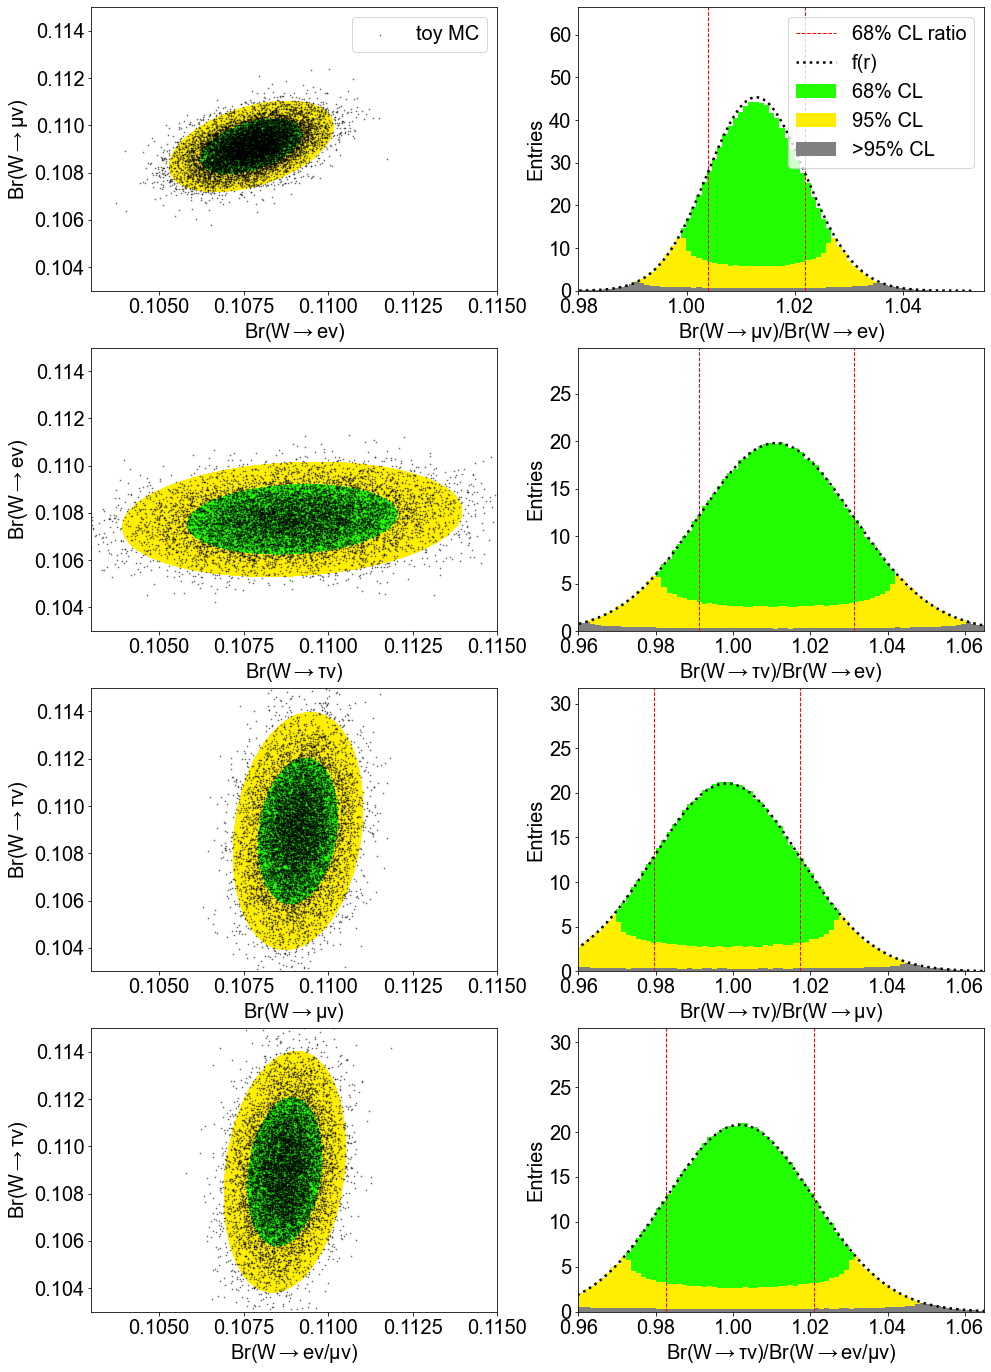

In [17]:
# sample the branching fractions and map to ratios

# plot the cost
fig, axes = plt.subplots(4, 2, figsize=(16, 24), facecolor='white', sharex=False, sharey=False)

ratios_1D = dict()

# electron vs. muon
cov_emu = cov_unblinded[:2, :2]
f_emu = multivariate_normal(mean=val_fit_unblinded[:2], cov=cov_unblinded[:2, :2])
nll_emu = -2*np.log(f_emu.pdf(pos)/f_emu.pdf(val_fit_unblinded[:2]))

# define sample points
n_total = int(1e6)
rand_emu_x, rand_emu_y = f_emu.rvs(size=n_total).T
f_emu_pdf = -2*np.log(f_emu.pdf(np.array([rand_emu_x, rand_emu_y]).T)/f_emu.pdf(val_fit_unblinded[:2]))
mask_1 = f_emu_pdf < clvls[1]
mask_2 = (f_emu_pdf >= clvls[1]) & (f_emu_pdf < clvls[2])
mask_3 = (f_emu_pdf >= clvls[2]) 

ax = axes[0][0]
ax.contourf(X, Y, nll_emu, levels=clvls, linestyles='solid', colors=['#22FF00', '#FFEE00'])
#ax.scatter([val_fit_unblinded[0]], [val_fit_unblinded[1]], marker='+', c='r', label='CMS')
ax.scatter(rand_emu_x[:10000], rand_emu_y[:10000], marker='.', c='k', s=2., alpha=0.5, label='toy MC')

# labels
ax.set_xlabel(label_emu['x'])
ax.set_ylabel(label_emu['y'])
ax.set_xlim(0.103, 0.115)
ax.set_ylim(0.103, 0.115)
ax.legend()

ax = axes[0][1]
ratio = rand_emu_y/rand_emu_x
pdf_weights = [np.exp(-f_emu_pdf[mask_3]/2), np.exp(-f_emu_pdf[mask_2]/2), np.exp(-f_emu_pdf[mask_1]/2)]
binning = np.linspace(0.95, 1.045, 100)
h, _, _ = ax.hist([ratio[mask_3], ratio[mask_2], ratio[mask_1]], 
                  bins=binning,
                  histtype='stepfilled', 
                  color=['gray', '#FFEE00', '#22FF00'], 
                  stacked=True, 
                  density=True, 
                  label=['>95% CL', '95% CL', '68% CL'],
                  #weights=pdf_weights
                 )
#h_weighted, _, _ = ax.hist(ratio,
#                           bins=binning,
#                           histtype='step', 
#                           color='C0', 
#                           stacked=True, 
#                           density=True, 
#                           label='weighted',
#                           weights=np.exp(-f_emu_pdf/2)
#                          )

cl68_up, cl68_down = np.sort(ratio)[int(0.84*n_total)], np.sort(ratio)[int(0.16*n_total)]
ax.plot([cl68_up, cl68_up], [0, 1.5*h.max()], color='r', linestyle='--', linewidth=1., label='68% CL ratio')
ax.plot([cl68_down, cl68_down], [0, 1.5*h.max()], color='r', linestyle='--', linewidth=1.)

# analytic expression from Hinkley
r_emu_pdf = partial(fh.bivariate_normal_ratio,
                    mu_x=val_fit_unblinded[0],
                    mu_y=val_fit_unblinded[1],
                    sigma_x=err_fit_unblinded[0], 
                    sigma_y=err_fit_unblinded[1],
                    rho=corr_unblinded.iloc[0, 1]
                   )
r_vals = np.linspace(0.95, 1.065, 1000)
ax.plot(1/r_vals, r_emu_pdf(r_vals), 'k:', label=r'f(r)')

# labels
ax.set_ylabel('Entries')
ax.set_xlabel(f'{label_emu["y"]}/{label_emu["x"]}')
ax.set_ylim(None, 1.5*h.max())
ax.set_xlim(0.98, 1.055)
ax.legend(loc=1)

ratio_median = ratio[ratio.size//2]
ratio_val = val_fit_unblinded[1]/val_fit_unblinded[0]
ratio_error = (np.abs(ratio_val - cl68_up) + np.abs(ratio_val - cl68_down))/2
print(f'emu : {ratio_val:.3f} +/- {ratio_error:.3f}; [{cl68_down:.3f}, {cl68_up:.3f}]')
ratios_1D['emu'] = (ratio_val, ratio_error)

### electron vs. tau ###
cov_etau = cov_unblinded[[2, 0]][:, [2, 0]]
val_etau = val_fit_unblinded[[2, 0]]
f_etau = multivariate_normal(mean=val_etau, cov=cov_etau)
nll_etau = -2*np.log(f_etau.pdf(pos)/f_etau.pdf(val_etau))

# define sample points
n_total = int(1e6)
rand_etau_x, rand_etau_y = f_etau.rvs(size=n_total).T
f_etau_pdf = -2*np.log(f_etau.pdf(np.array([rand_etau_x, rand_etau_y]).T)/f_etau.pdf(val_fit_unblinded[[2, 0]]))
mask_1 = f_etau_pdf < clvls[1]
mask_2 = (f_etau_pdf >= clvls[1]) & (f_etau_pdf < clvls[2])
mask_3 = (f_etau_pdf >= clvls[2]) 

ax = axes[1][0]
ax.contourf(X, Y, nll_etau, levels=clvls, linestyles='solid', colors=['#22FF00', '#FFEE00'])
#ax.scatter([val_fit_unblinded[0]], [val_fit_unblinded[1]], marker='+', c='r', label='CMS')
ax.scatter(rand_etau_x[:10000], rand_etau_y[:10000], marker='.', c='k', s=2., alpha=0.5, label='toy MC')

# labels
ax.set_xlabel(label_etau['x'])
ax.set_ylabel(label_etau['y'])
ax.set_xlim(0.103, 0.115)
ax.set_ylim(0.103, 0.115)

ax = axes[1][1]
ratio = rand_etau_x/rand_etau_y
pdf_weights = [np.exp(-f_etau_pdf[mask_3]/2), np.exp(-f_etau_pdf[mask_2]/2), np.exp(-f_etau_pdf[mask_1]/2)]
binning = np.linspace(0.95, 1.08, 100)
h, _, _ = ax.hist([ratio[mask_3], ratio[mask_2], ratio[mask_1]], 
                  bins=binning,
                  histtype='stepfilled', 
                  color=['gray', '#FFEE00', '#22FF00'], 
                  stacked=True, 
                  density=True, 
                  label=['>95% CL', '95% CL', '68% CL'],
                  #weights=pdf_weights
                 )

cl68_up, cl68_down = np.sort(ratio)[int(0.84*n_total)], np.sort(ratio)[int(0.16*n_total)]
ax.plot([cl68_up, cl68_up], [0, 1.5*h.max()], color='r', linestyle='--', linewidth=1., label='68% CL ratio')
ax.plot([cl68_down, cl68_down], [0, 1.5*h.max()], color='r', linestyle='--', linewidth=1.)

# analytic expression from Hinkley
r_etau_pdf = partial(fh.bivariate_normal_ratio,
                    mu_x=val_fit_unblinded[2],
                    mu_y=val_fit_unblinded[0],
                    sigma_x=err_fit_unblinded[2], 
                    sigma_y=err_fit_unblinded[0],
                    rho=corr_unblinded.iloc[2, 0]
                   )
r_vals = np.linspace(0.95, 1.08, 1000)
ax.plot(r_vals, r_etau_pdf(r_vals), 'k:', label=r'$f(r_{\tau/e})$')

# labels
ax.set_ylabel('Entries')
ax.set_xlabel(f'{label_etau["x"]}/{label_etau["y"]}')
ax.set_ylim(None, 1.5*h.max())
ax.set_xlim(0.96, 1.065)

ratio_median = ratio[ratio.size//2]
ratio_val = val_fit_unblinded[2]/val_fit_unblinded[0]
ratio_error = (np.abs(ratio_val - cl68_up) + np.abs(ratio_val - cl68_down))/2
print(f'etau : {ratio_val:.3f} +/- {ratio_error:.3f}; [{cl68_down:.3f}, {cl68_up:.3f}]')
ratios_1D['etau'] = (ratio_val, ratio_error)

# muon vs tau
cov_mutau = cov_unblinded[1:, 1:]
val_mutau = val_fit_unblinded[1:]
f_mutau = multivariate_normal(mean=val_mutau, cov=cov_unblinded[1:, 1:])
nll_mutau = -2*np.log(f_mutau.pdf(pos)/f_mutau.pdf(val_fit_unblinded[1:]))

# define sample points
n_total = int(1e6)
rand_mutau_x, rand_mutau_y = f_mutau.rvs(size=n_total).T
f_mutau_pdf = -2*np.log(f_mutau.pdf(np.array([rand_mutau_x, rand_mutau_y]).T)/f_mutau.pdf(val_mutau))
mask_1 = f_mutau_pdf < clvls[1]
mask_2 = (f_mutau_pdf >= clvls[1]) & (f_mutau_pdf < clvls[2])
mask_3 = (f_mutau_pdf >= clvls[2]) 

ax = axes[2][0]
ax.contourf(X, Y, nll_mutau, levels=clvls, linestyles='solid', colors=['#22FF00', '#FFEE00'])
ax.scatter(rand_mutau_x[:10000], rand_mutau_y[:10000], marker='.', c='k', s=2., alpha=0.5, label='toy MC')

# labels
ax.set_xlabel(label_mutau['x'])
ax.set_ylabel(label_mutau['y'])
ax.set_xlim(0.103, 0.115)
ax.set_ylim(0.103, 0.115)

ax = axes[2][1]
ratio = rand_mutau_y/rand_mutau_x
pdf_weights = [np.exp(-f_mutau_pdf[mask_3]/2), np.exp(-f_mutau_pdf[mask_2]/2), np.exp(-f_mutau_pdf[mask_1]/2)]
binning = np.linspace(0.95, 1.08, 100)
h, _, _ = ax.hist([ratio[mask_3], ratio[mask_2], ratio[mask_1]], 
                  bins=binning,
                  histtype='stepfilled', 
                  color=['gray', '#FFEE00', '#22FF00'], 
                  stacked=True, 
                  density=True, 
                  label=['>95% CL', '95% CL', '68% CL'],
                 )

cl68_up, cl68_down = np.sort(ratio)[int(0.84*n_total)], np.sort(ratio)[int(0.16*n_total)]
ax.plot([cl68_up, cl68_up], [0, 1.5*h.max()], color='r', linestyle='--', linewidth=1., label='68% CL ratio')
ax.plot([cl68_down, cl68_down], [0, 1.5*h.max()], color='r', linestyle='--', linewidth=1.)

# analytic expression from Hinkley
r_mutau_pdf = partial(fh.bivariate_normal_ratio,
                    mu_x=val_fit_unblinded[2],
                    mu_y=val_fit_unblinded[1],
                    sigma_x=err_fit_unblinded[2], 
                    sigma_y=err_fit_unblinded[1],
                    rho=corr_unblinded.iloc[2, 1]
                   )
r_vals = np.linspace(0.95, 1.08, 1000)
ax.plot(r_vals, r_mutau_pdf(r_vals), 'k:', label=r'$f(r_{\tau/\mu})$')

# labels
ax.set_ylabel('Entries')
ax.set_xlabel(f'{label_mutau["y"]}/{label_mutau["x"]}')
ax.set_ylim(None, 1.5*h.max())
ax.set_xlim(0.96, 1.065)

ratio_median = ratio[ratio.size//2]
ratio_val = val_fit_unblinded[2]/val_fit_unblinded[1]
ratio_error = (np.abs(ratio_val - cl68_up) + np.abs(ratio_val - cl68_down))/2
ratios_1D['mutau'] = (ratio_val, ratio_error)

print(f'mutau : {ratio_val:.3f} +/- {ratio_error:.3f}; [{cl68_down:.3f}, {cl68_up:.3f}]')

# electron/muon vs tau #
err_ltau = [0.00074, 0.0021]
corr_ltau = np.array([[1., 0.196], [0.196, 1.]])
cov_ltau = corr_ltau*np.outer(err_ltau, err_ltau)
val_ltau = np.array([0.10872, 0.10892])
f_ltau = multivariate_normal(mean=val_ltau, cov=cov_ltau)
nll_ltau = -2*np.log(f_ltau.pdf(pos)/f_ltau.pdf(val_ltau))

# define sample points
n_total = int(1e6)
rand_ltau_x, rand_ltau_y = f_ltau.rvs(size=n_total).T
f_ltau_pdf = -2*np.log(f_ltau.pdf(np.array([rand_ltau_x, rand_ltau_y]).T)/f_ltau.pdf(val_ltau))
mask_1 = f_ltau_pdf < clvls[1]
mask_2 = (f_ltau_pdf >= clvls[1]) & (f_ltau_pdf < clvls[2])
mask_3 = (f_ltau_pdf >= clvls[2]) 

ax = axes[3][0]
ax.contourf(X, Y, nll_ltau, levels=clvls, linestyles='solid', colors=['#22FF00', '#FFEE00'])
ax.scatter(rand_ltau_x[:10000], rand_ltau_y[:10000], marker='.', c='k', s=2., alpha=0.5, label='toy MC')

# labels
ax.set_xlabel(label_ltau['x'])
ax.set_ylabel(label_ltau['y'])
ax.set_xlim(0.103, 0.115)
ax.set_ylim(0.103, 0.115)

ax = axes[3][1]
ratio = rand_ltau_y/rand_ltau_x
pdf_weights = [np.exp(-f_ltau_pdf[mask_3]/2), np.exp(-f_ltau_pdf[mask_2]/2), np.exp(-f_ltau_pdf[mask_1]/2)]
binning = np.linspace(0.95, 1.08, 100)
h, _, _ = ax.hist([ratio[mask_3], ratio[mask_2], ratio[mask_1]], 
                  bins=binning,
                  histtype='stepfilled', 
                  color=['gray', '#FFEE00', '#22FF00'], 
                  stacked=True, 
                  density=True, 
                  label=['>95% CL', '95% CL', '68% CL'],
                 )

cl68_up, cl68_down = np.sort(ratio)[int(0.84*n_total)], np.sort(ratio)[int(0.16*n_total)]
ax.plot([cl68_up, cl68_up], [0, 1.5*h.max()], color='r', linestyle='--', linewidth=1., label='68% CL ratio')
ax.plot([cl68_down, cl68_down], [0, 1.5*h.max()], color='r', linestyle='--', linewidth=1.)

# analytic expression from Hinkley
r_ltau_pdf = partial(fh.bivariate_normal_ratio,
                     mu_x=val_ltau[1],
                     mu_y=val_ltau[0],
                     sigma_x=err_ltau[1], 
                     sigma_y=err_ltau[0],
                     rho=corr_ltau[0, 1]
                    )
r_vals = np.linspace(0.95, 1.08, 1000)
ax.plot(r_vals, r_ltau_pdf(r_vals), 'k:', label=r'$f(r_{\tau/\mu})$')

# labels
ax.set_ylabel('Entries')
ax.set_xlabel(f'{label_ltau["y"]}/{label_ltau["x"]}')
ax.set_ylim(None, 1.5*h.max())
ax.set_xlim(0.96, 1.065)

ratio_median = ratio[ratio.size//2]
ratio_val = val_ltau[1]/val_ltau[0]
ratio_error = (np.abs(ratio_val - cl68_up) + np.abs(ratio_val - cl68_down))/2
ratios_1D['ltau'] = (ratio_val, ratio_error)

print(f'ltau : {ratio_val:.3f} +/- {ratio_error:.3f}; [{cl68_down:.3f}, {cl68_up:.3f}]')

plt.savefig('plots/CI_2D_to_1D.pdf')
plt.show()

/home/naodell/opt/anaconda3.7/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: divide by zero encountered in log


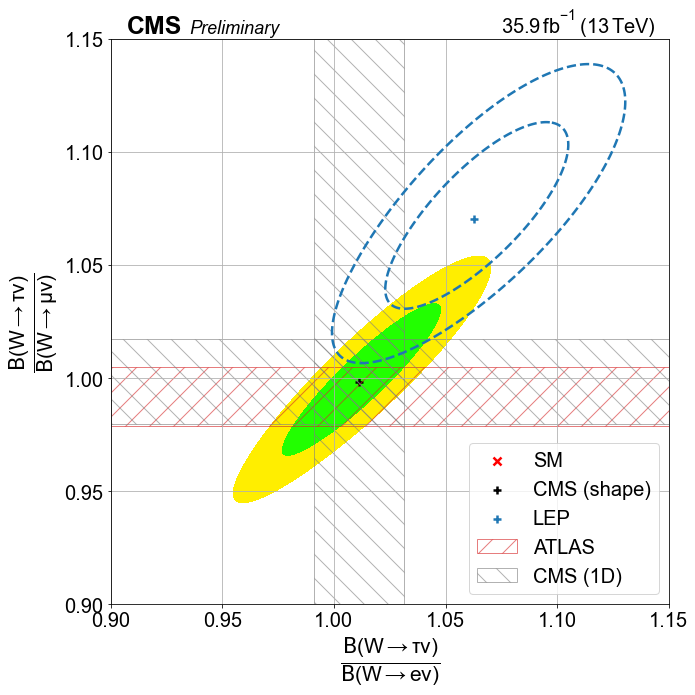

In [18]:
# plot the cost
fig, ax = plt.subplots(1, 1, figsize=(10, 10), facecolor='white', sharex=True, sharey=True)

# plot options
npoints = 1000
scan_range = (0.8, 1.15)

# define sample points
scan_vals = np.linspace(scan_range[0], scan_range[1], npoints)
X, Y = np.meshgrid(scan_vals, scan_vals)
pos = np.empty(X.shape + (2,))
pos[:,:,0] = X
pos[:,:,1] = Y

# SM expectation (temporarily set to (1, 1))
ax.scatter([1], [1], marker='x', color='r', label='SM')
    
# tua/e vs tau/mu (CMS shape)
ratio_mle = np.array([val_fit_unblinded[2]/val_fit_unblinded[0], val_fit_unblinded[2]/val_fit_unblinded[1]])
corr_br = np.array([corr_unblinded.iloc[0, 1], corr_unblinded.iloc[0, 2], corr_unblinded.iloc[1, 2]])
#corr_br = np.zeros(3)
ratio_pdf = partial(fh.trivariate_normal_ratio,
                    mu = val_fit_unblinded,
                    sigma = err_fit_unblinded,
                    rho = corr_br
                   )

R = np.vstack([X.flatten(), Y.flatten()])
nll_ratio = -2*np.log(ratio_pdf(R)/ratio_pdf(1/ratio_mle)) 
nll_ratio = nll_ratio.reshape(npoints, npoints)
ax.contourf(1/X, 1/Y, nll_ratio, levels=clvls, linestyles='solid', colors=['#22FF00', '#FFEE00'])
ax.scatter([ratio_mle[0]], [ratio_mle[1]], marker='+', c='k', label='CMS (shape)')

# tau/e vs tau/mu (CMS counting)
#ratio_mle = np.array([br_alt[2]/br_alt[0], br_alt[2]/br_alt[1]])
#corr_br = np.array([corr_alt[0, 1], corr_alt[0, 2], corr_alt[1, 2]])
#ratio_pdf = partial(fh.trivariate_normal_ratio,
#                    mu = br_alt,
#                    sigma = stderr_alt,
#                    rho = corr_br
#                   )
#
#R = np.vstack([X.flatten(), Y.flatten()])
#nll_ratio = -2*np.log(ratio_pdf(R)/ratio_pdf(1/ratio_mle)) 
##nll_ratio -= nll_ratio.min()
#nll_ratio = nll_ratio.reshape(npoints, npoints)
#ax.contour(1/X, 1/Y, nll_ratio, levels=clvls, linestyles='solid', colors='C4')
#ax.scatter([ratio_mle[0]], [ratio_mle[1]], marker='+', c='C4', label='CMS (counting)')

# LEP
ratio_lep = np.array([br_lep[2]/br_lep[0], br_lep[2]/br_lep[1]])
corr_br = np.array([corr_lep[0, 1], corr_lep[0, 2], corr_lep[1, 2]])
#corr_br = np.zeros(3)
ratio_pdf = partial(fh.trivariate_normal_ratio,
                    mu = br_lep,
                    sigma = stderr_lep,
                    rho = corr_br
                   )

R = np.vstack([X.flatten(), Y.flatten()])
nll_ratio = -2*np.log(ratio_pdf(R)/ratio_pdf(1/ratio_lep)) 
nll_ratio -= nll_ratio.min()
nll_ratio = nll_ratio.reshape(npoints, npoints)
ax.contour(1/X, 1/Y, nll_ratio, levels=clvls, linestyles='--', colors='C0')
ax.scatter([ratio_lep[0]], [ratio_lep[1]], marker='+', c='C0', label='LEP')

# ATLAS
r_atlas, err_atlas = 0.992, 0.013
ax.fill_between([0.9, 1.15], [r_atlas-err_atlas, r_atlas-err_atlas], [r_atlas+err_atlas, r_atlas+err_atlas], 
                edgecolor='C3', 
                facecolor='none',
                hatch='/',
                alpha=0.6,
                label='ATLAS'
               )

# TEST from 1D case
ratio_etau = ratios_1D['etau']
ratio_mutau = ratios_1D['mutau']
ax.fill_between([0.9, 1.15], 2*[ratio_mutau[0]-ratio_mutau[1],], 2*[ratio_mutau[0]+ratio_mutau[1],], 
                edgecolor='gray', 
                facecolor='none',
                hatch='\\',
                alpha=0.6,
                label='CMS (1D)'
               )
ax.fill_betweenx([0.9, 1.15], 2*[ratio_etau[0]-ratio_etau[1],], 2*[ratio_etau[0]+ratio_etau[1],], 
                 edgecolor='gray', 
                 facecolor='none',
                 hatch='\\',
                 alpha=0.6,
                 label='_nolabel_'
             )

# labels
ax.set_xlabel(r'$\frac{\mathcal{B}(W\rightarrow \tau\nu)}{\mathcal{B}(W\rightarrow e\nu)}$', size=30)
ax.set_ylabel(r'$\frac{\mathcal{B}(W\rightarrow \tau\nu)}{\mathcal{B}(W\rightarrow \mu\nu)}$', size=30)
ax.set_xlim(0.9, 1.15)
ax.set_ylim(0.9, 1.15)
ax.legend(loc=4)
ax.grid()

pt.add_lumi_text(ax, 35.9)

plt.tight_layout()
plt.savefig('plots/result_contours_2d_ratio.pdf')
plt.savefig('plots/result_contours_2d_ratio.png')
plt.show()